# Laplacian Associative Memory (LAM) - DEV

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch, PIL.Image, imageio
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from nn_torch import LAM
import libtools

---

#### IMAGE & FAST FOURIER

In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
# img = libtools.downsample(img, 2) # Downsample
img = img[:100,:100] # Crop
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.02 max: 1.00


---

In [5]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [6]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 12


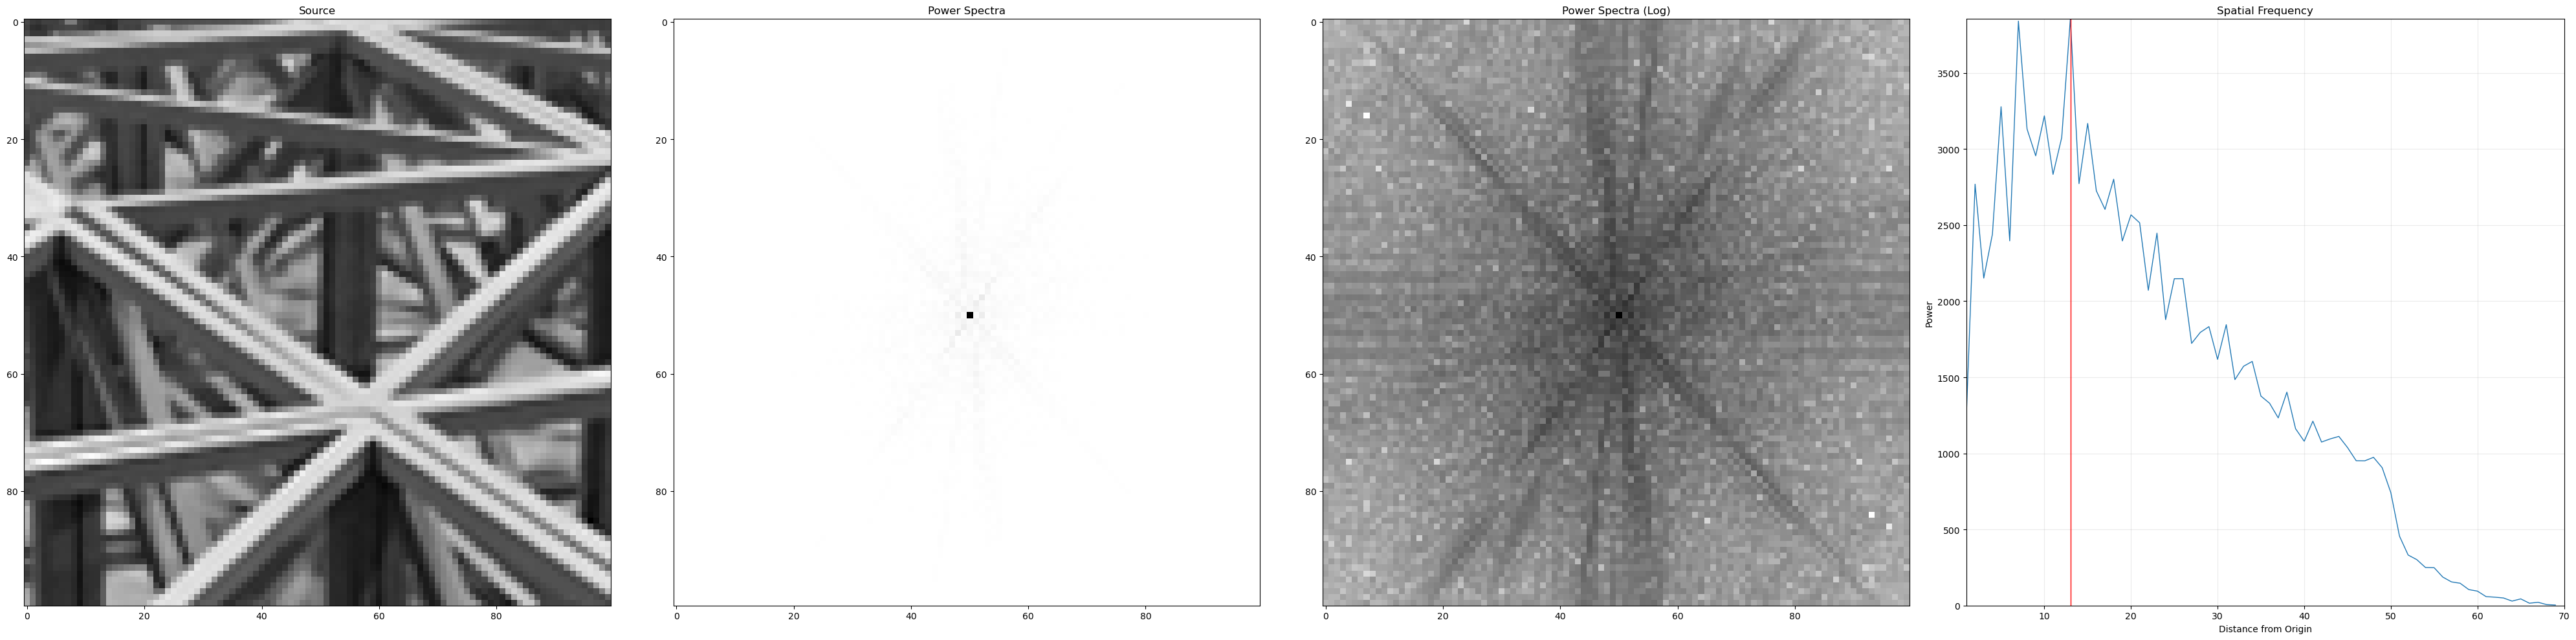

In [7]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

---

In [8]:
src = libtools.preference_map(16, count*2, img.shape[0]) # x2 power of spatial frequency FFT

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


---

In [9]:
step = count

pad = int(step/2)
pad_im = np.pad(img, pad, mode='constant', constant_values=0)
features = np.zeros_like(pad_im)

for i in range(src.shape[0]):
    for j in range(src.shape[1]):
        rad = src[i][j] - np.pi # -π and π
        deg = np.rad2deg(rad)
        kernel = libtools.gabor_filter(1, 10, deg, step) # Orientation
        patch = pad_im[i:i+step, j:j+step]
        features[int(i+pad),int(j+pad)] = np.sum(patch * kernel) # Firing Rate / Response

features = features[pad:pad+src.shape[0],pad:pad+src.shape[1]]
features[features<=0] = 0 # Rectify
features /= np.max(features)

In [10]:
print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


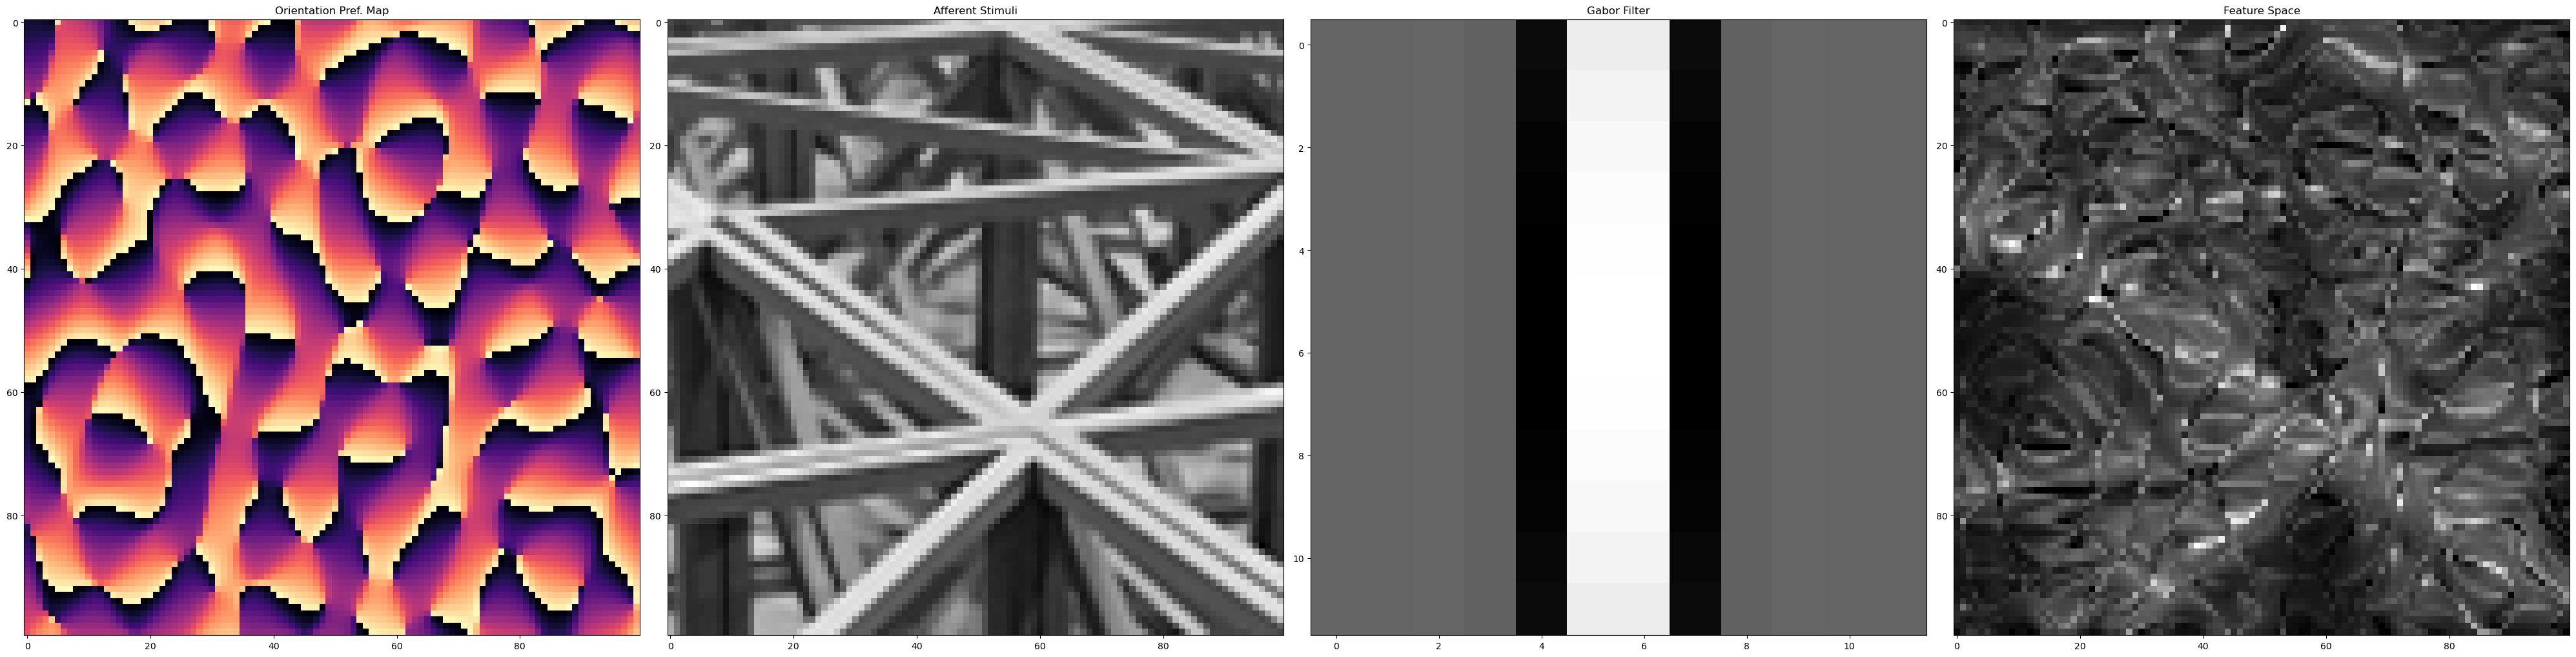

In [11]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,10,0, samples=int(step)), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

### HYPER-PARAMETERS

In [12]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-6                        # Spatial Gaussian Scale
sigmaA = 0.1                          # Angular Gaussian Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE

In [13]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Correlation Matrix

In [14]:
# Convert to tensor
img = torch.from_numpy(img).float()
features = torch.from_numpy(features).float()
W = torch.from_numpy(W).float()

In [15]:
graph = LAM(N, P, prob, W, gamma, "asym") # Decompose Weights

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [16]:
# Afferent initial condition
I = np.zeros_like(graph.xi)
for node in range(graph.xi.shape[1]):
    state = (graph.xi[:, node].clone() * 2) - 1
    I[:,node] = state * features.flatten()[node]

Inorm = np.sum(I, axis=1) * 1/graph.xi.shape[1]
act = libtools.boltzmann_prob(Inorm, 0.0925)

print("Sparsity:", np.sum(act/np.size(act)))

init_state = torch.from_numpy(act).float()

Sparsity: 0.09222412109375


In [17]:
m_log, p_log, e_log = graph.simulate_single(alpha, eta, simlen, start_node, init_state.clone()) # Simulate

Using feature-based initial condition


100%|██████████| 3000/3000 [01:53<00:00, 26.36it/s]


In [18]:
m = m_log[-1,:].clone()
# m[start_node] = np.mean(np.delete(m, start_node))

Nactive = torch.mean(torch.sum((m > 0.5*m.max()).float() * (m > 0.0), dim=0))
print("Maximum overlap:", m.max())
print("Number of patterns:", Nactive)

Maximum overlap: tensor(0.0043)
Number of patterns: tensor(438.)


---

### PLOT

In [19]:
# HSV2RGB
m_norm = m + abs(m.min())
m_norm /= m_norm.max()

hsv_pattern = libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape))
hsv_features = libtools.grade(src/(2*np.pi), 1.0, features.reshape(src.shape))

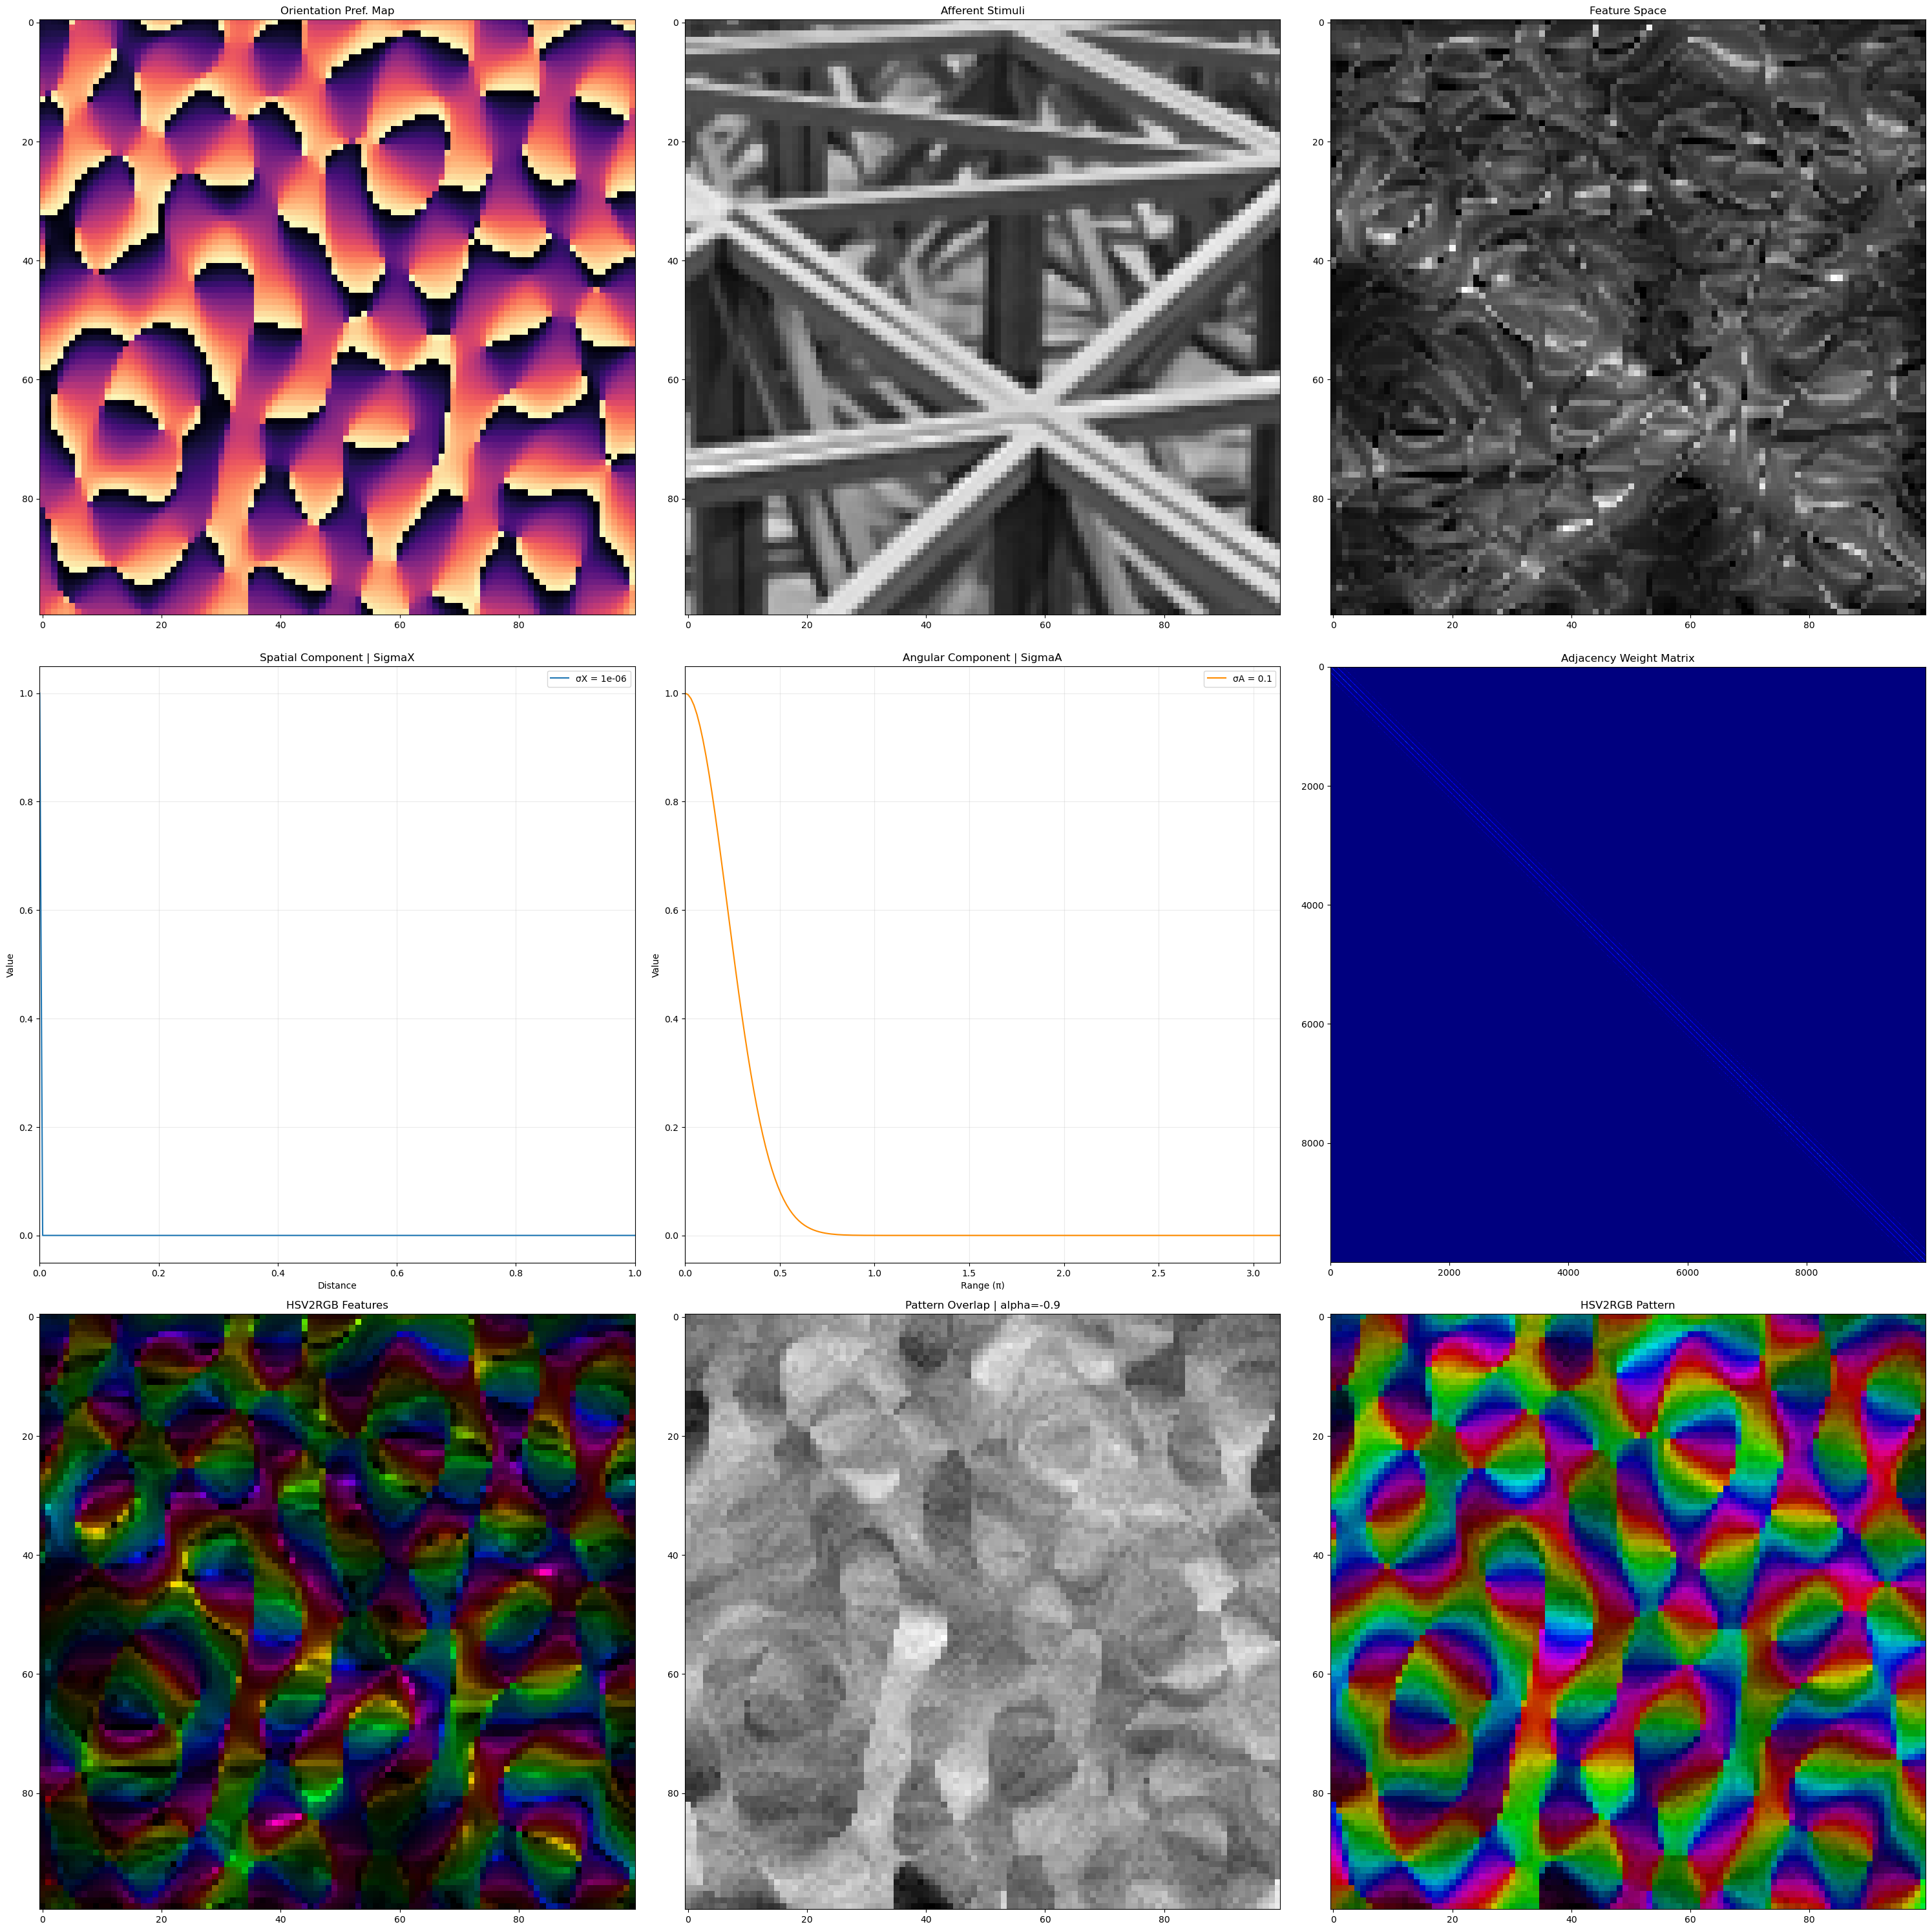

In [20]:
plt.figure(figsize=(30,30))
plt.subplot(3, 3, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(3, 3, 2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(3, 3, 3)
plt.imshow(features, 'gray')
plt.title('Feature Space')

plt.subplot(3, 3, 4)
dist_s = np.linspace(0, 1, 200)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Distance'), plt.ylabel('Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(3, 3, 5)
dist_a = np.linspace(0, np.pi, 200)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range (π)'), plt.ylabel('Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(3, 3, 6)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(3, 3, 7)
plt.imshow(hsv_features)
plt.title("HSV2RGB Features")

plt.subplot(3, 3, 8)
plt.imshow(m.reshape(src.shape), 'gray')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(3, 3, 9)
plt.imshow(hsv_pattern)
plt.title("HSV2RGB Pattern")

plt.tight_layout()

---

### NEURAL STRUCTURE

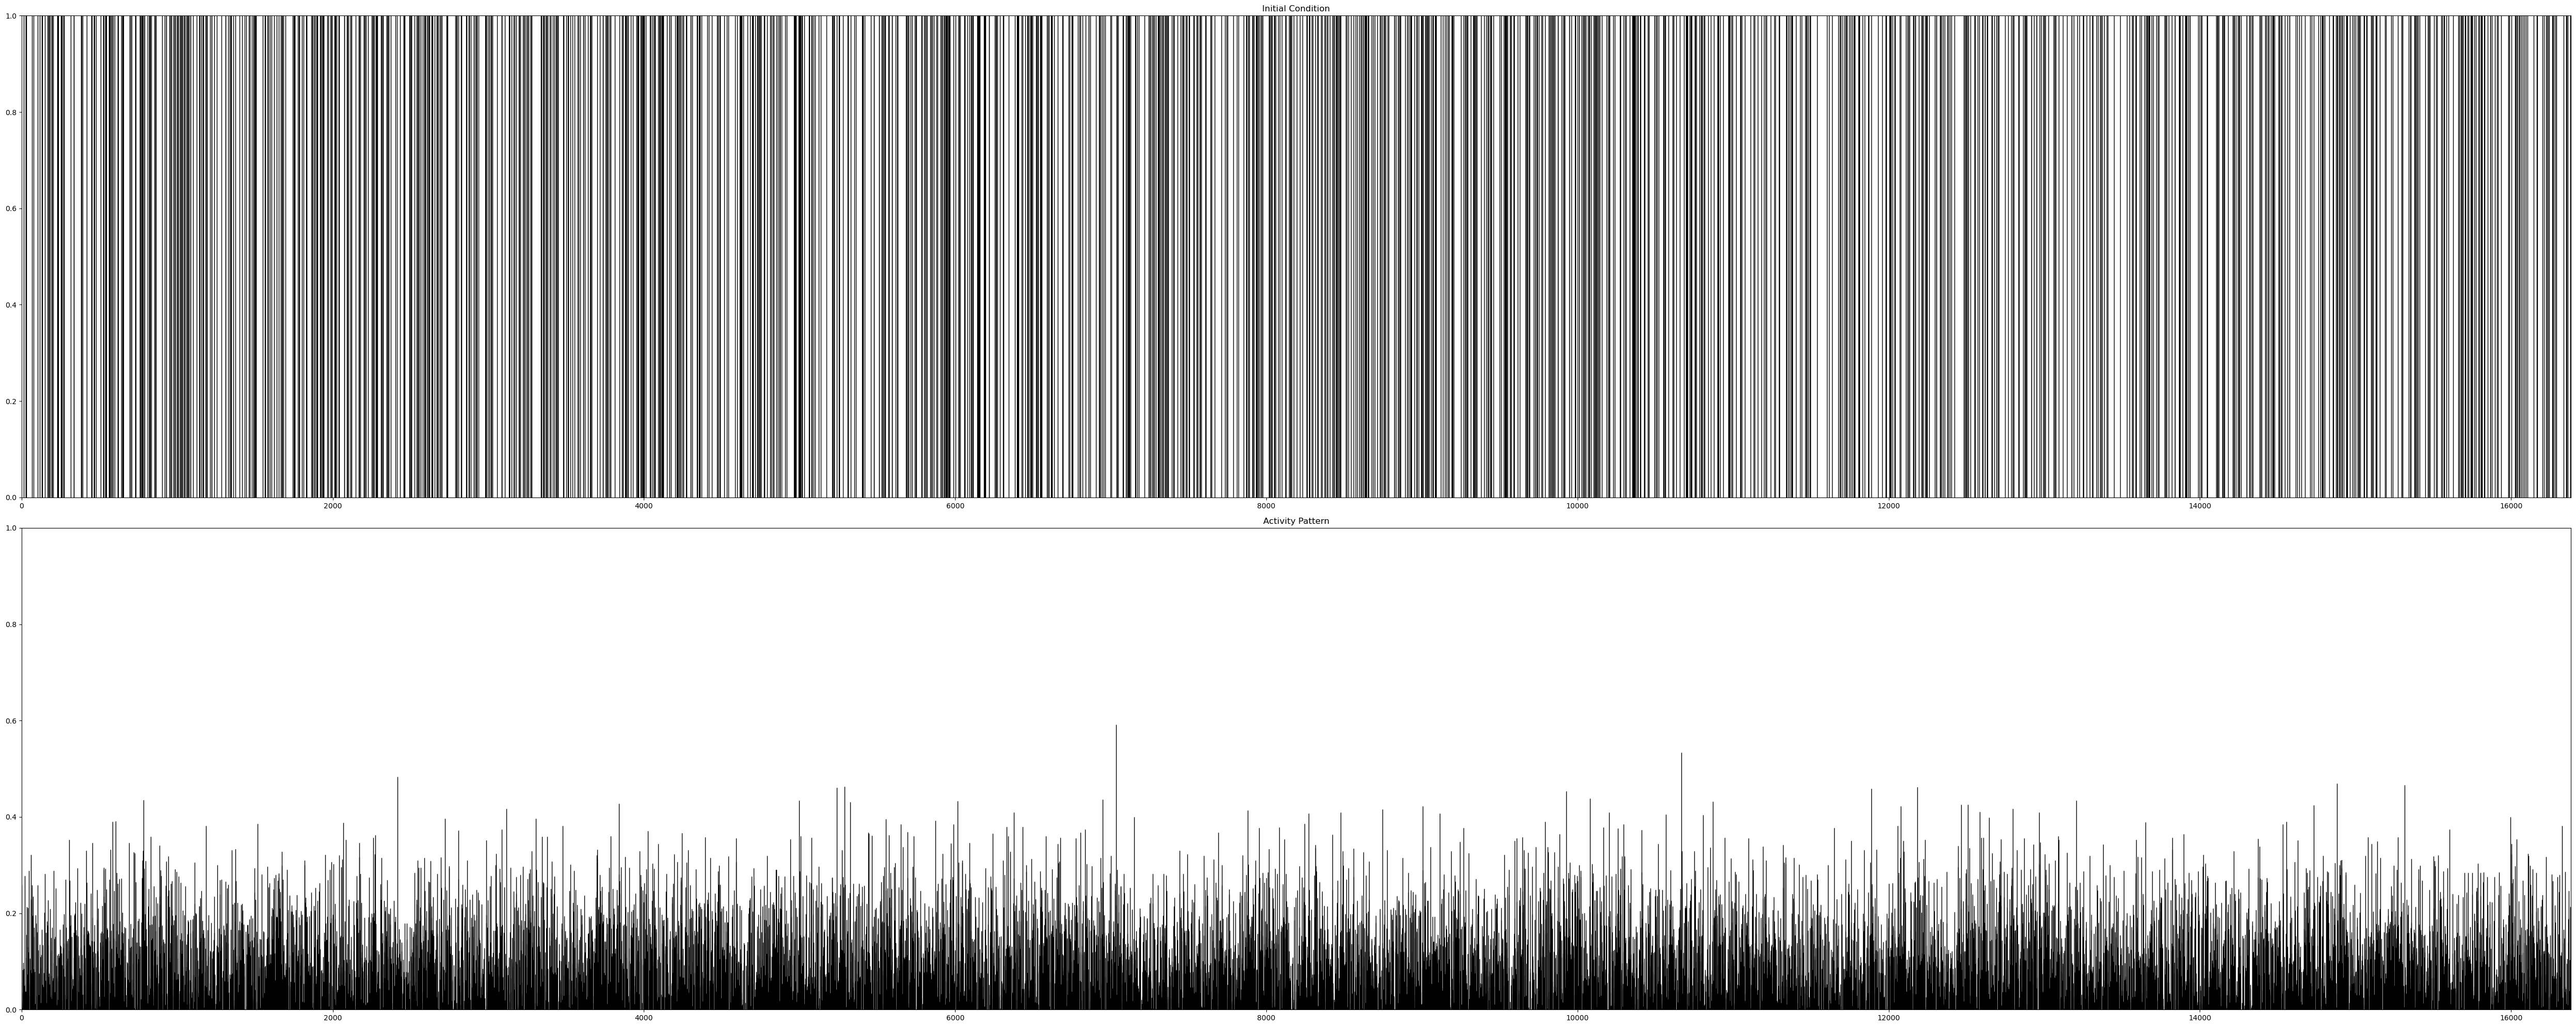

In [21]:
plt.figure(figsize=(50, 20))
plt.subplot(2,1,1)
for i in range(len(init_state)):
    if init_state[i].numpy()==1.0:
        plt.vlines(i, 0, 1, linewidth=1, color='k')

plt.title("Initial Condition")
plt.xlim([0, len(init_state)]), plt.ylim([0, 1])

plt.subplot(2,1,2)
for i in range(len(graph.x)):
    if graph.x[i].numpy()!=0.0:
        plt.vlines(i, 0, graph.x[i].numpy(), linewidth=1, color='k')

plt.title("Activity Pattern")
plt.xlim([0, len(graph.x)]), plt.ylim([0, 1])
plt.tight_layout()

---

### RENDER

In [22]:
# libtools.render(m_log.reshape([simlen, src.shape[0], src.shape[1]]), 10, '../data/render/DEV/patternSim_DEV.gif', 'gray') # Pattern Overlap

In [23]:
# libtools.render(p_log.reshape([simlen, dim, dim]), 10, '../data/render/DEV/stateSim_DEV.gif', 'gray') # State Stabilisation

In [24]:
# hsv_log = []
# for i in range(m_log.shape[0]):
#     if i%10==0:
#         m = m_log[i,:].clone()
#         # m[start_node] = np.mean(np.delete(m, start_node))
#         m_norm = m + abs(m.min())
#         m_norm /= m_norm.max()

#         hsv_log.append(libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape)))

# hsv_log = np.array(hsv_log)

# imageio.mimsave("../data/render/DEV/patternSim_hsv_DEV.gif", np.uint8(hsv_log * 255.0))